<a href="https://www.kaggle.com/code/zulqarnain11/cats-vs-dogs-classifier-efficientnet?scriptVersionId=291694177" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #0a141b; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #7ab052; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">
        🐱🐶 Cats & Dogs Classifier: 🥇 High Accuracy with EfficientNet!
    </h1>
</div>


## 1. Problem Statement
<div style="font-size:18px; line-height:1.6; margin-bottom:10px;">

<p>Given a dataset of cat and dog images, the task is to develop a machine learning model that can accurately classify between cats and dogs in an image.</p>
</div>


## 2. About Dataset
<div style="font-size:18px; line-height:1.6; color:#333;">
<p>This dataset contains over 1000 images of cats and dogs scraped from Google Images. The task is to build a model that can classify between cats and dogs accurately.</p>
<ul style="font-size:18px;>
<li>Image sizes vary from roughly 100x100 pixels to 2000x1000 pixels.</li>
<li>All images are in JPEG format.</li>
<li>Duplicates have been removed.</li>
</ul>
</div>


## 3. Import Libraries

In [24]:
import os
import numpy as np
import pandas as pd
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input


import warnings
warnings.filterwarnings("ignore")  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 



## 4. Loading Dataset
<div style="font-size:18px; line-height:1.6; margin-bottom:10px;">
<p>Download and prepare the Cats and Dogs dataset for training and validation.</p>
</div>


In [25]:
class Config:
    def __init__(self):
        self.image_size = (224, 224)
        self.batch_size = 32
        self.epochs = 50
        self.autotune = tf.data.AUTOTUNE

config = Config()


In [26]:
train_dir='/kaggle/input/cats-and-dogs-image-classification/train'
val_dir='/kaggle/input/cats-and-dogs-image-classification/test'

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=config.image_size,
    batch_size=config.batch_size,
    shuffle=True,

)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=config.image_size,
    batch_size=config.batch_size,


)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.
Classes: ['cats', 'dogs']


In [27]:
print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(val_ds)}")

Train size: 18
Test size: 5


In [28]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))


train_ds = train_ds.prefetch(config.autotune)
val_ds    = val_ds.prefetch(config.autotune)


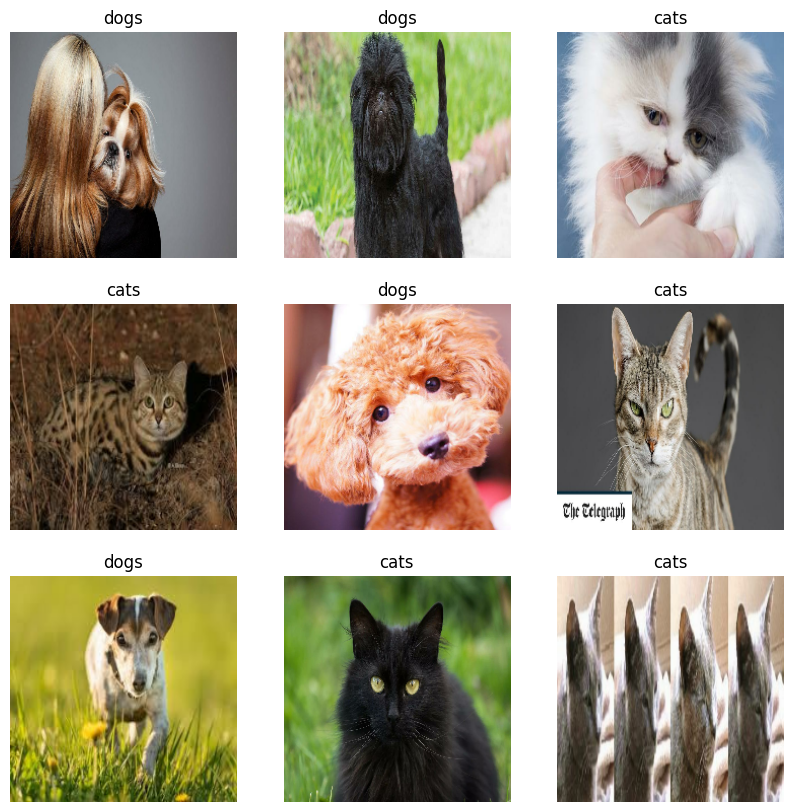

In [29]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow((images[i]).numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



## 5. Data Augmentation
<div style="font-size:18px; line-height:1.6; margin-bottom:10px;">
<p>Apply random flips, rotations, and zooms to increase dataset diversity.</p>
</div>


In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


## 6. Build Model
<div style="font-size:18px; line-height:1.6; margin-bottom:10px;">
<p>Using EfficientNetB0 as base, followed by pooling, dropout, and dense layers.</p>
</div>


In [31]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [32]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## 7. Train Model
<div style="font-size:18px; line-height:1.6; margin-bottom:10px;">
<p>Use EarlyStopping to prevent overfitting.</p>
</div>


In [33]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.epochs,
        callbacks=[early_stopping]
    )



Epoch 1/50


E0000 00:00:1768325416.838878      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.7977 - loss: 0.3907 - val_accuracy: 0.9786 - val_loss: 0.1218
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9525 - loss: 0.1142 - val_accuracy: 0.9571 - val_loss: 0.1607
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9741 - loss: 0.0680 - val_accuracy: 0.9714 - val_loss: 0.1305
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9709 - loss: 0.0611 - val_accuracy: 0.9714 - val_loss: 0.1038
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9867 - loss: 0.0428 - val_accuracy: 0.9357 - val_loss: 0.2563
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9614 - loss: 0.0806 - val_accuracy: 0.9714 - val_loss: 0.1565
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9921 - loss: 0.0334 - val_accuracy: 0.9643 - val_loss: 0.1503


## 8.  Results



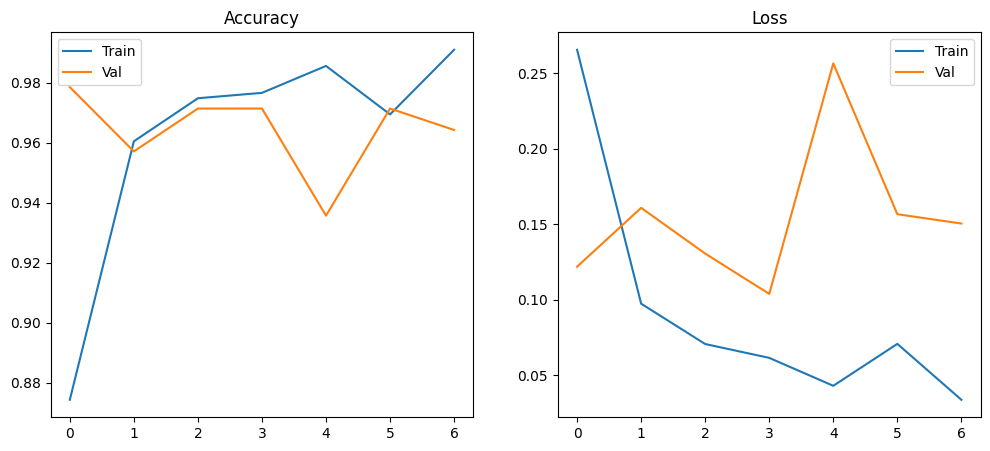

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()



## 9. Confusion Matrix & Classification Report



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


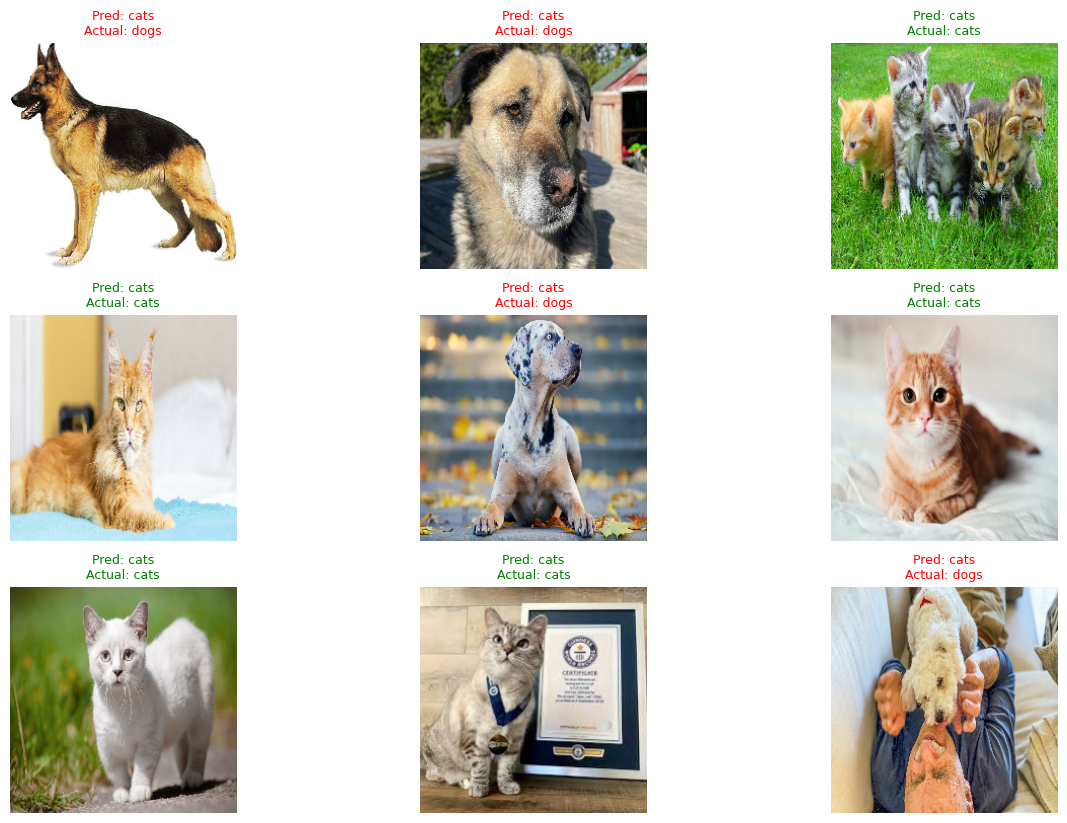

In [35]:
plt.figure(figsize=(15, 10))

for images, labels in val_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i]).numpy().astype("uint8"))
        color = "green" if preds[i] == labels[i] else "red"
        plt.title(
            f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}",
            color=color,
            fontsize=9
        )
        plt.axis("off")

plt.show()


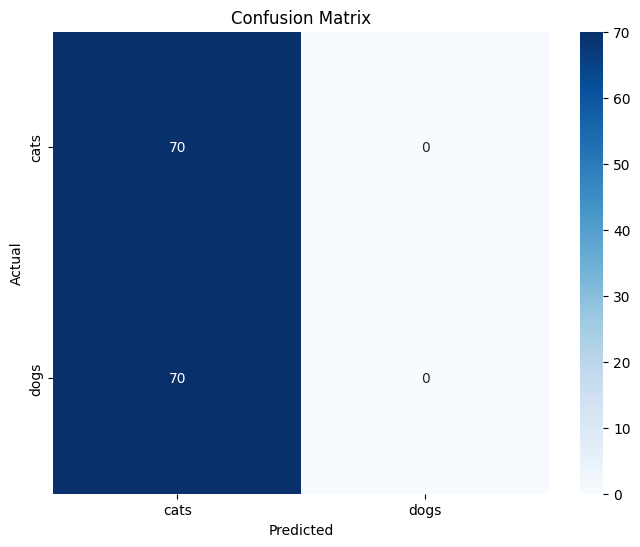

In [36]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = np.argmax(model.predict(images, verbose=0), axis=1)  # silent predictions
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()





## 🎯 Conclusion
<div style="border-radius: 20px; border: 2px solid #00ea98; padding: 20px; background-color: #0a141b; text-align: center; box-shadow: 0px 2px 4px rgba(0,0,0,0.2); margin-top:20px;">
<h2 style="color: #7ab052; text-shadow: 2px 2px 4px rgba(0,0,0,0.5); font-weight:bold;">
</h2>
<p style="color:white;">
We successfully trained a binary classifier to distinguish cats and dogs using EfficientNetB0. Early stopping helped prevent overfitting and achieved high accuracy on the validation set.
</p>
</div>
